
![logo](./kfupm-logo.png)
## <center> ICS 485: Machine Learning
### <center> <font color=crimson> App Review Classification


<center>
         <font color="pink" size=5> Team Members
        
        # Mawiah Alboainain
        # Yousef Alzahrani


    
    
Table of Contents
* [Exploratory Analysis](#first-bullet)
* [Imbalanced Data](#fourth-bullet)
* [Evaluation Measures](#fifth-bullet)
* [Classifiers](#sixth-bullet)
* [Hyper-parameter Tuning ](#seventh-bullet)
* [Error Analysis](#eighth-bullet)
* [Results](#ninth-bullet)
* [Conclusion](#tenth-bullet)


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#text editing libraries
import nlpaug
import nlpaug.augmenter.word as naw
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize



In [4]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]"," ",str(text)) #force string
    text = re.sub(r"(^|\W)\d+", "", text)
    text = text.lower()
    lemmatizer=WordNetLemmatizer()
    text=word_tokenize(text)
    tmp =''
    for word in text:
        tmp+=lemmatizer.lemmatize(word)+' '
    text = tmp
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [5]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=10)   
def text_augment(text):
    return aug.augment(text,n=1)

In [19]:
def undersample(df):
    classes = df.label.value_counts().to_dict()
    downsize = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)):
        classes_sample.append(classes_list[i].sample(downsize, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [18]:
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    to_augment =  max(classes.values()) - np.array(list(classes.values()))
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        to_paraphrase = classes_list[i].sample(to_augment[i], replace=True)
        to_paraphrase.review = to_paraphrase.apply(lambda x: text_augment(x['review']), axis=1)
        classes_sample.append(to_paraphrase)
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0],classes_list[1],classes_list[2],classes_list[3]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [20]:
dataset_url = "https://raw.githubusercontent.com/ZYousef/CS485-Project/main/AppReviews-FourClasses.csv"
df = pd.read_csv(dataset_url)

## <center><font color=purple> 1. Exploratory Data Analysis<a class="anchor" id="first-bullet"></a>

### <font color=blue> A. Dataset Analysis & Important Statistics

In [6]:
df.head()

,review,label
0,"Besides the occasional crash, this is an amazi...",Bug
1,This could be a great app if it was predictabl...,Bug
2,I can't open since the last 2 updates Pop-ups ...,Bug
3,Use to love this app but it's not working afte...,Bug
4,"Urrrrm\tAfter my third re installing, it final...",Bug


In [7]:
df.describe()

,review,label
count,3733,3733
unique,3217,4
top,Good,Rating
freq,15,2461


We have 3733 reviews, 3217 of them are unique.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3733 entries, 0 to 3732
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3733 non-null   object
 1   label   3733 non-null   object
dtypes: object(2)
memory usage: 58.5+ KB


In [9]:
samples,classes=df.shape[0],df.nunique()[1]

In [10]:
samples,classes

(3733, 4)

We have 3733 Samples & 4 unique classes

In [11]:
df.label.value_counts()

Rating            2461
UserExperience     607
Bug                370
Feature            295
Name: label, dtype: int64

Rating, UserExperience, Bug & Features are the four unique classes. We can also notice an imbalance in classes with Rating dominating by a large margin.

In [12]:
#Some reviews contains special string such as \t & \n for tabs and new line
df[df.review.str.contains("\t")].shape[0],df[df.review.str.contains("\n")].shape[0]

(1491, 238)

In [13]:
df.review = df.review.str.replace("\n"," ")
df.review = df.review.str.replace("\t"," ")

In [14]:
df[df.review.str.contains("\t")].shape[0],df[df.review.str.contains("\n")].shape[0]

(0, 0)

In [15]:
df[df.duplicated()]

,review,label
223,"The white app icon is so atrocious, I'm hiding...",Bug
714,Nice,Rating
752,Good Good,Rating
786,Good,Rating
820,Ok,Rating
...,...,...
3060,Good Cool,Rating
3063,Ok Ok,Rating
3075,Great app,Rating
3085,Ok,Rating


We notice 137 entries are duplicated

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df[df.duplicated()]

,review,label


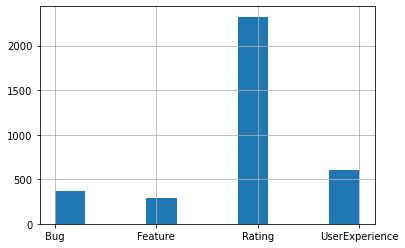

In [18]:
df.label.hist();

In [19]:
 df.label.value_counts()

Rating            2324
UserExperience     607
Bug                369
Feature            295
Name: label, dtype: int64

In [20]:
 df.label.value_counts()

Rating            2324
UserExperience     607
Bug                369
Feature            295
Name: label, dtype: int64

## <center><font color=purple>4. Imbalanced Data<a class="anchor" id="fourth-bullet"></a>

In [21]:
#Blanaces the data and makes sure new aguments data duplicates are <=25 or reached limit
df_balanced = oversample(df)
dups = df_balanced.duplicated().sum()
num_iter=0
while num_iter < 10 & dups > 25 :
    df_balanced.drop_duplicates(inplace=True)
    df_balanced = oversample(df)
    dups = df_balanced.duplicated().sum()
    num_iter+=1
#Make sure original dataset is embedded 
pd.merge(df,df_balanced,how='inner').shape[0]

3684

In [22]:
df_balanced.to_csv('balanced.csv',index=False)

In [23]:
df_balanced = pd.read_csv('balanced.csv')

In [24]:
df_balanced.label.value_counts()

UserExperience    2324
Bug               2324
Feature           2324
Rating            2324
Name: label, dtype: int64

### <font color=blue> B. Correlation Analysis

In [25]:
df_balanced.review = df_balanced.apply(lambda x: clean_text(x['review']), axis=1)

In [26]:
df_balanced['review'].str.lower().str.split().apply(len).groupby(df_balanced.label).describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Bug,2324.0,40.406196,36.205128,2.0,19.0,31.0,49.0,278.0
Feature,2324.0,37.811102,35.534369,3.0,18.0,29.5,45.0,277.0
Rating,2324.0,13.885972,19.373360,0.0,3.0,7.0,17.0,272.0
UserExperience,2324.0,33.649312,30.247588,1.0,13.0,25.0,45.0,260.0


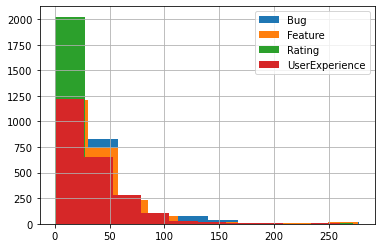

In [27]:
df_balanced['review'].str.lower().str.split().apply(len).groupby(df_balanced.label).hist(legend=True);

#### Ratings review are relatively short

In [28]:
df_balanced['label_id'] = df_balanced['label'].factorize()[0] #digitze? label to int
label_id_df_balanced = df_balanced[['label', 'label_id']].sort_values('label_id') #sort
label_to_id = dict(label_id_df_balanced.values)
id_to_label = dict(label_id_df_balanced[['label_id', 'label']].values)

In [29]:
X,Y = df_balanced['review'], df_balanced['label']
trainx, testx, trainy, testy = train_test_split(X, Y, test_size=0.3, random_state=777)

In [30]:
#Text represntation
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(trainx).toarray()
labels = trainy.factorize()[0]
features.shape

(6507, 48595)

In [31]:
N = 2
for label, label_id in sorted(label_to_id.items()):
  features_chi2 = chi2(features, labels == label_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bug':
  . Most correlated unigrams:
. love
. game
  . Most correlated bigrams:
. whatsapp sm
. useful easy
# 'Feature':
  . Most correlated unigrams:
. trip
. easy
  . Most correlated bigrams:
. trip advisor
. easy use
# 'Rating':
  . Most correlated unigrams:
. nice
. good
  . Most correlated bigrams:
. good good
. information technology
# 'UserExperience':
  . Most correlated unigrams:
. fix
. crash
  . Most correlated bigrams:
. update fix
. latest update


## <center><font color=purple>5. Evaluation Measures <a class="anchor" id="fifth-bullet"></a>

#### In our project we're going to use the classification report provided by sklearn
#### It is a performance evaluation metric in machine learning which is used to show the precision, recall, F1 Score, and support score of your trained classification model.
    
    sklearn.metrics.classification_report
#### Check [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report) for more details 

 

# <font color=red> ADD JUSTIFICATION

## <center><font color=purple>6. Classifers <a class="anchor" id="sixth-bullet"></a>

* Naive Bayes
* Logistic Regression
* Support Victor Machines (Linear & SGD)
* Random Forest

# <font color=red> ADD JUSTIFICATION & DESCRIPTION FOR EACH CLASSIFIER

## <center><font color=purple>7. Hyper-parameter Tuning <a class="anchor" id="seventh-bullet"></a>

#### In this section we've pipelined all of our classifiers to automate the process of tunning the paramters using GridSearchCV , 

    from sklearn.model_selection import GridSearchCV


#### If you want to know the results of GridSearchCV use,

    clf.best_estimator_

## Naive Bayes

In [32]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2,1e-3,1e-4]
}
#tuned_parameters = {}

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.8992    0.9692    0.9329       681
       Feature     0.8403    0.9582    0.8954       670
        Rating     0.8171    0.6059    0.6959       708
UserExperience     0.7807    0.8192    0.7995       730

      accuracy                         0.8351      2789
     macro avg     0.8343    0.8381    0.8309      2789
  weighted avg     0.8332    0.8351    0.8288      2789



## Logisitc Regression

In [40]:
# Using logistic regression as a classification model using Spark
# Building the model
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0, C=1e5)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__n_jobs': [1,2],
}

# Fitting the model built above in the training set and then testing it
# and printing different reports along with the accuracy 
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.9235    0.9574    0.9402       681
       Feature     0.9167    0.9030    0.9098       670
        Rating     0.7113    0.7585    0.7341       708
UserExperience     0.7934    0.7260    0.7582       730

      accuracy                         0.8333      2789
     macro avg     0.8362    0.8362    0.8356      2789
  weighted avg     0.8339    0.8333    0.8329      2789



## Support Vector Machine (SVM)

#### A) SVM with SGD training

In [33]:
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(random_state=42)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2,1e-3,1e-4],
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__penalty':['l2', 'l1', 'elasticnet'],
    'clf__max_iter': [1000,2000,3000]
}

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.9233    0.9721    0.9471       681
       Feature     0.8859    0.9731    0.9275       670
        Rating     0.8194    0.7048    0.7578       708
UserExperience     0.8102    0.8068    0.8085       730

      accuracy                         0.8612      2789
     macro avg     0.8597    0.8642    0.8602      2789
  weighted avg     0.8583    0.8612    0.8580      2789



#### B) Linear SVM

In [41]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(random_state=42)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'clf__penalty':['l2', 'l1'],
}

clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")

## Testing the model and printing the accuracy
regr.fit(trainx, trainy)
print(classification_report(testy, regr.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.9057    0.9736    0.9384       681
       Feature     0.9050    0.9522    0.9280       670
        Rating     0.7883    0.7415    0.7642       708
UserExperience     0.8236    0.7740    0.7980       730

      accuracy                         0.8573      2789
     macro avg     0.8557    0.8603    0.8572      2789
  weighted avg     0.8542    0.8573    0.8549      2789



# Random Forest 

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=0)),
               ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__stop_words':['english'],
    'vect__encoding':['latin-1'],
    'vect__min_df':[1,2,3],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_depth': [3,4,5],
    'clf__n_estimators':[200, 300],
}

from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy")
clf.fit(trainx, trainy)

print(classification_report(testy, clf.predict(testx), digits=4))

                precision    recall  f1-score   support

           Bug     0.7397    0.7386    0.7392       681
       Feature     0.6787    0.7597    0.7169       670
        Rating     0.5967    0.7669    0.6712       708
UserExperience     0.7261    0.4466    0.5530       730

      accuracy                         0.6744      2789
     macro avg     0.6853    0.6780    0.6701      2789
  weighted avg     0.6852    0.6744    0.6678      2789



## <font color=orange> Notes

#### <font color=orange>Undersampling using our method without libraries performed around 43% accuracy.
        undersample(df);

#### <font color=orange>Use,
    
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
#### <font color=orange>Then include it as follows:

        text_clf = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('RUS', RandomOverSampler()),  *OR*  ('RUS', RandomUnderSampler()), 
                        ('clf', MultinomialNB())])

#### <font color=orange>Undersampling using library resulted in around 50% accuracy 
#### <font color=orange>Oversampling performed better at around 64% accuracy
#### <font color=orange>However, our best result was through data augmenting by generating new parapharsed data. 

## <center><font color=purple>8. Error Analysis & Possible Improvements <a class="anchor" id="eighth-bullet"></a>

# <font color=red> Possible Discussions :
* Using different text augmentation
* Oversampling Training data only instead of the whole dataset.( just to be safe)
* Training RandomForest with tunned DecisionTree as base_estimator
    
# I DON"T KNOW WHAT ELSE I JUST WORTE THESE QUICKLY, FEEL FREE TO ASK FOR EXPLAINATION :)


## <center><font color=purple>9. Final Results <a class="anchor" id="ninth-bullet"></a>

# <font color=red> Summarize Classification Report for Each

| Classifier| Accuracy |  |
| --- | --- | --- |
| Naive Bayes |  | 0.8351       |
| Logisitc Regression |  | 0.8333       |
| SVM SGD |  | 0.8612       |
| SVM Linear |  | 0.8573       |
| RandomForest |  | 0.6744       |

## <center><font color=purple>10. Conclusion <a class="anchor" id="tenth-bullet"></a>

# <font color=red> Machine Learning is good.
# <font color=red> Tunned Model performs better. 
# <font color=red> Talk About <font color=blue>"TRASH IN TRASH OUT"</font> CONCEPT JUST TO LOOK SMARTASS.